# DM-34065: rotation test 1 
    
* Turn off all perturbations in (ts_)phosim.
* Simulate a single star exactly on the boresight.
* Estimate Zernikes.  You _should_ find that only Z4, Z11, Z22 are non-zero.
* Repeat for different rotations (shouldn’t matter if you tweak rotTelPos or rotSkyPos).  You _should_ find that all the Zernikes here are independent of the rotation angle.  I.e., the ones that start out at zero are still zero, and the others are constant with rotation angle.

Ticket: https://jira.lsstcorp.org/browse/DM-34065

We can turn off all added perturbations by setting `m1m3Ferr` to 0, so that [genMirSurfRandErr()](https://github.com/lsst-ts/ts_phosim/blob/e25ac907d0385b109caf1ee4a803d9f248b54096/python/lsst/ts/phosim/telescope/M1M3Sim.py#L582) doesn't do anything (`myu` is `LUT` ) . 

Run one iteration with a single star on the boresight. That can be done by providing no `skyFile` so that stars are simulated at the default OPD locations, which for ComCam are the center of each CCD (https://github.com/lsst-ts/ts_phosim/blob/467a40d106d41c82c2d561a4593b33221f9b6ff3/python/lsst/ts/phosim/CloseLoopTask.py#L107).


However, by default the `CloseLoopTask` does 

    tele = TeleFacade()
    tele.addSubSys(addCam=True, addM1M3=True, addM2=True)
        
( https://github.com/lsst-ts/ts_phosim/blob/467a40d106d41c82c2d561a4593b33221f9b6ff3/python/lsst/ts/phosim/CloseLoopTask.py#L211  ). So I take the relevant parts of `CloseLoopTask`, and run them in a notebook, changing that part. 




I write  a function that would take parts of `imgCloseLoop` https://github.com/lsst-ts/ts_phosim/blob/develop/python/lsst/ts/phosim/CloseLoopTask.py#L211 . Most of the methods can be used directly, I only had to paste here parts of `configPhosimCmpt` and edit `addSubsys` part. 

In [54]:
%matplotlib inline
import os
import sys
sys.path.append('/project/scichris/aos/')
import analysisTools as at
import imp
imp.reload(at)

import os
import shutil
import logging

import astropy.io.ascii

import numpy as np

from lsst.afw.cameraGeom import DetectorType
from lsst.daf import butler as dafButler
from lsst.ts.phosim.CloseLoopTask import CloseLoopTask

In [55]:
# test_01 : had tele.addSubSys(addCam=True, addM1M3=False, addM2=False)  - still had izernike, rotCam = 0 
# test_01_a : did not have that (so that addCam = False) - had no izernike commands , rotCam = 0
# test_01_a_30:  same as 01_a , but rotCam of 30 
# test_01_a_60 : same as 01_a,  but rotCam of 60 
# test_01_a_30n ; same as 01_a, but rotCam of -30 

#

def runCloseLoopTask(baseOutputDir,
                     rotCamInDeg=0,
                     iterNum=1,
                     numPro=20,
                     boresight=[0,0],
                     pathSkyFile='',
                     useEimg=False,
                     inst='comcam',
                     filterTypeName='',
                     m1m3ForceError=0,
                     zAngleInDeg=27.0912,
                     seedNum=6,
                     ):
    '''A convenience function to run the CloseLoopTask
    without adding any subsystems, i.e. izernike 
    commands in the cmd file. The docstring for 
    parameters is same as that for parts within
    CloseLoopTask. Copied here for convenience.
    
    Parameters:
    ----------
    baseOutputDir : str 
        Base output directory.
    rotCamInDeg: int, optional
        The camera rotation angle in degrees (-90 to 90).
    iterNum : int, optional 
            Number of closed-loop iterations (default is 1).
    numPro : int, optional
        Number of processors to run PhoSim and DM pipeline (default is 20)
    boresight : list[float], optional
        Boresight [ra, dec] in degrees (default  [0,0])
    pathSkyFile : str, optional
        Path to the sky file (default: '')
    useEimg : bool, optional
        Use the eimage or not (default: False)
    inst : str, optional 
        Instrument to use: comcam or lsstfam (default is comcam)
    filterTypeName : str, optional 
        Filter type name: '', u, g, r, i, z, or y (default is '').
        NB: 'ref' should work the same as '', but it doesn't work for 
        ts_ofc, see https://github.com/lsst-ts/ts_phosim/issues/61
    m1m3ForceError : float, optional
            Ratio of M1M3 actuator force error between 0 and 1
            (default is 0).
    zAngleInDeg : float, optional
            Zenith angle in degree of telescope
            (default is 27.0912.)
    seedNum : int, optional
            Seed number for the M1M3 mirror surface purturbation
            (default is 6)
    '''
    
    # initialize the task afresh 
    closeLoop = CloseLoopTask()

    camType, instName = closeLoop.getCamTypeAndInstName(inst)
    
    filterType = closeLoop.getFilterType(filterTypeName)

    print(baseOutputDir)
    baseOutputDir = closeLoop.checkAndCreateBaseOutputDir(baseOutputDir)

    closeLoop.checkBoresight(boresight, pathSkyFile)
    
    closeLoop.assignImgType(useEimg)

    closeLoop.configSkySim(instName, pathSkyFile=pathSkyFile, starMag=15)

    if pathSkyFile == "":
        pathSkyFile = os.path.join(baseOutputDir, "sky_info.txt")
        closeLoop.skySim.exportSkyToFile(pathSkyFile)
        closeLoop.log.info(f"Wrote new sky file to {pathSkyFile}.")
    
    closeLoop.configOfcCalc(instName)

    # 
    # begin self.configPhosimCmpt
    #          

    rotAngInDeg = rotCamInDeg
    
    closeLoop.boresightRa = boresight[0]
    closeLoop.boresightDec = boresight[1]
    closeLoop.boresightRotAng = rotAngInDeg

    # Set the Telescope facade class
    tele = TeleFacade()
    #tele.addSubSys(addCam=True, addM1M3=False, addM2=False)

    phosimDir = getPhoSimPath()
    tele.setPhoSimDir(phosimDir)

    # Prepare the phosim component
    closeLoop.phosimCmpt = PhosimCmpt(tele)

    # Set the telescope survey parameters
    closeLoop.phosimCmpt.setSurveyParam(
        filterType=filterType,
        boresight=tuple(boresight),
        zAngleInDeg=zAngleInDeg,
        rotAngInDeg=rotAngInDeg,
    )

    # Set the M1M3 force error
    closeLoop.phosimCmpt.setM1M3ForceError(m1m3ForceError)

    # Update the number of processor if necessary
    if numPro > 1:
        settingFile = closeLoop.phosimCmpt.getSettingFile()
        settingFile.updateSetting("numPro", numPro)

    # Set the seed number for M1M3 surface
    closeLoop.phosimCmpt.setSeedNum(seedNum)


    #
    # end of self.configPhosimCmpt
    # 


    # generate butler gen3 repo if needed
    butlerRootPath = os.path.join(baseOutputDir, "phosimData")
    if closeLoop.useCcdImg():
        closeLoop.generateButler(butlerRootPath, instName)
        closeLoop.generateRefCatalog(
            instName=instName,
            butlerRootPath=butlerRootPath,
            pathSkyFile=pathSkyFile,
        )
    
    # set the camType
    closeLoop.phosimCmpt.tele.setInstName(camType)

    # Run just one iteration of the simulation
    closeLoop._runSim(
                camType=camType,
                instName=instName,
                filterType=filterTypeName,
                rotCamInDeg=rotCamInDeg,
                iterNum=iterNum,
                numPro=numPro,
                baseOutputDir=baseOutputDir,
                butlerRootPath=butlerRootPath,
            )

Run the above for a variety of rotation angles:

In [56]:
for rotCamInDeg in [-30,30,60]:   
    #set the output dir based on the rotation angle 
    if rotCamInDeg < 0:
        title = f'{str(rotCamInDeg)[1:]}n'
    else:
        title = f'{rotCamInDeg}'

    baseOutputDir = f'/project/scichris/aos/rotation_DM-34065/test01_a_{title}/'
    runCloseLoopTask(baseOutputDir,
                     rotCamInDeg=rotCamInDeg)

/project/scichris/aos/rotation_DM-34065/test01_a_30n/
lsst.LsstCamMapper WARN: Unable to find valid calib root directory
lsst.CameraMapper INFO: Loading Posix exposure registry from /project/scichris/aos/rotation_DM-34065/test01_a_30n/phosimData/skydata
root INFO: Running: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_tasks/g0f82ab2f21+a33241c25f/bin/ingestReferenceCatalog.py /project/scichris/aos/rotation_DM-34065/test01_a_30n/phosimData/skydata /project/scichris/aos/rotation_DM-34065/test01_a_30n/phosimData/skydata/sky_data.csv --configfile /project/scichris/aos/rotation_DM-34065/test01_a_30n/phosimData/skydata/cat.cfg
IngestIndexedReferenceTask INFO: Creating 131072 file locks.


/software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_base/g26724298ab+308922cbb4/python/lsst/pipe/base/argumentParser.py:782: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  namespace.butler = dafPersist.Butler(outputs=outputs)
/software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_base/g26724298ab+308922cbb4/python/lsst/pipe/base/argumentParser.py:782: FutureWarning: Gen2 Butler has been deprecated (LsstCamMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  namespace.butler = dafPersist.Butler(outputs=outputs)


IngestIndexedReferenceTask INFO: File locks created.
IngestIndexedReferenceTask INFO: Completed 1 / 1 files: 100 % complete 
root WARN: Unable to retrieve exit status ('NoneType' object is not iterable); assuming success


py.warnings WARNING: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/daf_butler/gbc02ca69e9+7f943868d5/python/lsst/daf/butler/cli/utils.py:883: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  func(*args, **kwargs)

py.warnings WARNING: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/daf_butler/gbc02ca69e9+7f943868d5/python/lsst/daf/butler/cli/utils.py:883: FutureWarning: Gen2 Butler has been deprecated (LsstCamMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  func(*args, **kwargs)

lsst.LsstCamMapper WARNING: Unable to find valid calib root directory
lsst.CameraMapper INFO: Loading Posix exposure registry from /project/scichris/aos/rotation_DM-34065/test01_a_30n/phosimData/skydata
daf.persistence.butler DEBUG: Releasing shared lock on /project/scichris/aos/rotation_DM-34065/test01_a_30n/phosimData/skydata/repos

Opsim_obshistid 9006000 
Opsim_filter 1 
rightascension 0.000000 
declination 0.000000 
rotskypos -30.000000 

Opsim_obshistid 9006001 
Opsim_filter 1 
mjd 59580.0000000000 
SIM_SEED 1000 
rightascension 0.000000 
declination 0.000000 
rotskypos -30.000000 

Opsim_obshistid 9006002 
Opsim_filter 1 
mjd 59580.0000000000 
SIM_SEED 1000 
rightascension 0.000000 
declination 0.000000 
rotskypos -30.000000 

Repackaging sensor R22_S00
Saved as /project/scichris/aos/rotation_DM-34065/test01_a_30n/iter0/img/tmp/CC_H_20211231_006002_R22_S00.fits
Repackaging sensor R22_S01
Saved as /project/scichris/aos/rotation_DM-34065/test01_a_30n/iter0/img/tmp/CC_H_20211231_006002_R22_S01.fits
Repackaging sensor R22_S10
Saved as /project/scichris/aos/rotation_DM-34065/test01_a_30n/iter0/img/tmp/CC_H_20211231_006002_R22_S10.fits
Repackaging sensor R22_S11
Saved as /project/scichris/aos/rotation_DM-34065/test01_a_30n/iter0/img/tmp/CC_H_20211231_006002_R22_S11.fits
Repackaging sensor R22_S12
Saved as /project/

lsst.ingest INFO: Successfully extracted metadata from 7 files with 0 failures
lsst.ingest INFO: Exposure LSSTComCam:CC_H_20211231_006002 ingested successfully
lsst.ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
lsst.ingest INFO: Ingested 7 distinct Butler datasets
lsst.ingest INFO: Successfully extracted metadata from 7 files with 0 failures
lsst.ingest INFO: Exposure LSSTComCam:CC_H_20211231_006001 ingested successfully
lsst.ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
lsst.ingest INFO: Ingested 7 distinct Butler datasets
lsst.obs.base.defineVisits INFO: Defaulting to searching for raw exposures in collection LSSTComCam/raw/all
lsst.defineVisits INFO: Preprocessing data IDs.
lsst.defineVisits INFO: Registering visit_system 1: by-group-metadata.
lsst.defineVisits INFO: Grouping 2 exposure(s) into visits.
lsst.defi

lsst.isr INFO: Widening saturation trails.
lsst.isr WARNING: No rough magnitude zero point defined for filter g_01.
lsst.isr INFO: Setting rough magnitude zero point for filter g_01: 30.940228
lsst.isr INFO: Widening saturation trails.
lsst.isr INFO: Applying gain correction instead of flat.
lsst.isr INFO: Widening saturation trails.
lsst.isr INFO: Applying gain correction instead of flat.
lsst.isr INFO: Assembling CCD from amplifiers.
lsst.isr WARNING: No rough magnitude zero point defined for filter g_01.
lsst.isr INFO: Setting rough magnitude zero point for filter g_01: 30.940228
lsst.isr INFO: Applying gain correction instead of flat.
lsst.isr INFO: Widening saturation trails.
lsst.isr INFO: Widening saturation trails.
lsst.isr INFO: Widening saturation trails.
lsst.isr INFO: Applying gain correction instead of flat.
lsst.isr INFO: Applying gain correction instead of flat.
lsst.isr INFO: Applying gain correction instead of flat.
lsst.isr INFO: Assembling CCD from amplifiers.
lsst.i

lsst.ctrl.mpexec.mpGraphExecutor INFO: Executed 11 quanta successfully, 0 failed and 24 remain out of total 35 quanta.
lsst.meas.algorithms.loadReferenceObjects.ReferenceObjectLoader INFO: Loading reference objects from cal_ref_cat in region bounded by [0.04282985, 0.36356430], [-0.27847842, 0.04372008] RA Dec
lsst.meas.algorithms.loadReferenceObjects.ReferenceObjectLoader INFO: Loaded 1 reference objects
lsst.generateDonutCatalogWcsTask.referenceSelector INFO: Selected 1/1 references
lsst.generateDonutCatalogWcsTask INFO: Running Donut Selector
lsst.ctrl.mpexec.singleQuantumExecutor INFO: Execution of task 'isr' on quantum {instrument: 'LSSTComCam', detector: 3, exposure: 4021123106001, ...} took 23.354 seconds
lsst.ctrl.mpexec.singleQuantumExecutor INFO: Execution of task 'isr' on quantum {instrument: 'LSSTComCam', detector: 1, exposure: 4021123106002, ...} took 23.648 seconds
lsst.ctrl.mpexec.mpGraphExecutor INFO: Executed 12 quanta successfully, 0 failed and 23 remain out of total 

lsst.ctrl.mpexec.singleQuantumExecutor INFO: Execution of task 'estimateZernikesScienceSensorTask' on quantum {instrument: 'LSSTComCam', detector: 0} took 2.121 seconds
lsst.ctrl.mpexec.mpGraphExecutor INFO: Executed 30 quanta successfully, 0 failed and 5 remain out of total 35 quanta.
lsst.ctrl.mpexec.singleQuantumExecutor INFO: Execution of task 'estimateZernikesScienceSensorTask' on quantum {instrument: 'LSSTComCam', detector: 7} took 27.345 seconds
lsst.ctrl.mpexec.mpGraphExecutor INFO: Executed 31 quanta successfully, 0 failed and 4 remain out of total 35 quanta.
lsst.ctrl.mpexec.singleQuantumExecutor INFO: Execution of task 'estimateZernikesScienceSensorTask' on quantum {instrument: 'LSSTComCam', detector: 1} took 27.670 seconds
lsst.ctrl.mpexec.mpGraphExecutor INFO: Executed 32 quanta successfully, 0 failed and 3 remain out of total 35 quanta.
lsst.ctrl.mpexec.singleQuantumExecutor INFO: Execution of task 'estimateZernikesScienceSensorTask' on quantum {instrument: 'LSSTComCam', 

/project/scichris/aos/rotation_DM-34065/test01_a_30/
lsst.LsstCamMapper WARN: Unable to find valid calib root directory
lsst.CameraMapper INFO: Loading Posix exposure registry from /project/scichris/aos/rotation_DM-34065/test01_a_30/phosimData/skydata
root INFO: Running: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_tasks/g0f82ab2f21+a33241c25f/bin/ingestReferenceCatalog.py /project/scichris/aos/rotation_DM-34065/test01_a_30/phosimData/skydata /project/scichris/aos/rotation_DM-34065/test01_a_30/phosimData/skydata/sky_data.csv --configfile /project/scichris/aos/rotation_DM-34065/test01_a_30/phosimData/skydata/cat.cfg
IngestIndexedReferenceTask INFO: Creating 131072 file locks.


/software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_base/g26724298ab+308922cbb4/python/lsst/pipe/base/argumentParser.py:782: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  namespace.butler = dafPersist.Butler(outputs=outputs)
/software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_base/g26724298ab+308922cbb4/python/lsst/pipe/base/argumentParser.py:782: FutureWarning: Gen2 Butler has been deprecated (LsstCamMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  namespace.butler = dafPersist.Butler(outputs=outputs)


IngestIndexedReferenceTask INFO: File locks created.
IngestIndexedReferenceTask INFO: Completed 1 / 1 files: 100 % complete 
root WARN: Unable to retrieve exit status ('NoneType' object is not iterable); assuming success


py.warnings WARNING: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/daf_butler/gbc02ca69e9+7f943868d5/python/lsst/daf/butler/cli/utils.py:883: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  func(*args, **kwargs)

py.warnings WARNING: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/daf_butler/gbc02ca69e9+7f943868d5/python/lsst/daf/butler/cli/utils.py:883: FutureWarning: Gen2 Butler has been deprecated (LsstCamMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  func(*args, **kwargs)

lsst.LsstCamMapper WARNING: Unable to find valid calib root directory
lsst.CameraMapper INFO: Loading Posix exposure registry from /project/scichris/aos/rotation_DM-34065/test01_a_30/phosimData/skydata
daf.persistence.butler DEBUG: Releasing shared lock on /project/scichris/aos/rotation_DM-34065/test01_a_30/phosimData/skydata/reposit

Opsim_obshistid 9006000 
Opsim_filter 1 
rightascension 0.000000 
declination 0.000000 
rotskypos 30.000000 

Opsim_obshistid 9006001 
Opsim_filter 1 
mjd 59580.0000000000 
SIM_SEED 1000 
rightascension 0.000000 
declination 0.000000 
rotskypos 30.000000 

Opsim_obshistid 9006002 
Opsim_filter 1 
mjd 59580.0000000000 
SIM_SEED 1000 
rightascension 0.000000 
declination 0.000000 
rotskypos 30.000000 

Repackaging sensor R22_S01
Saved as /project/scichris/aos/rotation_DM-34065/test01_a_30/iter0/img/tmp/CC_H_20211231_006002_R22_S01.fits
Repackaging sensor R22_S02
Saved as /project/scichris/aos/rotation_DM-34065/test01_a_30/iter0/img/tmp/CC_H_20211231_006002_R22_S02.fits
Repackaging sensor R22_S10
Saved as /project/scichris/aos/rotation_DM-34065/test01_a_30/iter0/img/tmp/CC_H_20211231_006002_R22_S10.fits
Repackaging sensor R22_S11
Saved as /project/scichris/aos/rotation_DM-34065/test01_a_30/iter0/img/tmp/CC_H_20211231_006002_R22_S11.fits
Repackaging sensor R22_S12
Saved as /project/scichri

lsst.ingest INFO: Successfully extracted metadata from 7 files with 0 failures
lsst.ingest INFO: Exposure LSSTComCam:CC_H_20211231_006002 ingested successfully
lsst.ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
lsst.ingest INFO: Ingested 7 distinct Butler datasets
lsst.ingest INFO: Successfully extracted metadata from 7 files with 0 failures
lsst.ingest INFO: Exposure LSSTComCam:CC_H_20211231_006001 ingested successfully
lsst.ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
lsst.ingest INFO: Ingested 7 distinct Butler datasets
lsst.obs.base.defineVisits INFO: Defaulting to searching for raw exposures in collection LSSTComCam/raw/all
lsst.defineVisits INFO: Preprocessing data IDs.
lsst.defineVisits INFO: Registering visit_system 1: by-group-metadata.
lsst.defineVisits INFO: Grouping 2 exposure(s) into visits.
lsst.defi

lsst.isr WARNING: No rough magnitude zero point defined for filter g_01.
lsst.isr INFO: Setting rough magnitude zero point for filter g_01: 30.940228
lsst.isr INFO: Widening saturation trails.
lsst.isr WARNING: No rough magnitude zero point defined for filter g_01.
lsst.isr INFO: Setting rough magnitude zero point for filter g_01: 30.940228
lsst.isr INFO: Assembling CCD from amplifiers.
lsst.isr INFO: Assembling CCD from amplifiers.
lsst.isr INFO: Applying gain correction instead of flat.
lsst.isr WARNING: No rough magnitude zero point defined for filter g_01.
lsst.isr INFO: Setting rough magnitude zero point for filter g_01: 30.940228
lsst.isr INFO: Widening saturation trails.
lsst.isr INFO: Applying gain correction instead of flat.
lsst.isr INFO: Widening saturation trails.
lsst.isr INFO: Widening saturation trails.
lsst.isr INFO: Widening saturation trails.
lsst.isr INFO: Assembling CCD from amplifiers.
lsst.isr INFO: Applying gain correction instead of flat.
lsst.isr INFO: Applying

lsst.ctrl.mpexec.singleQuantumExecutor INFO: Execution of task 'generateDonutCatalogWcsTask' on quantum {instrument: 'LSSTComCam', detector: 5, visit: 4021123106002, ...} took 8.172 seconds
lsst.ctrl.mpexec.mpGraphExecutor INFO: Executed 10 quanta successfully, 0 failed and 25 remain out of total 35 quanta.
lsst.ctrl.mpexec.mpGraphExecutor INFO: Executed 11 quanta successfully, 0 failed and 24 remain out of total 35 quanta.
lsst.ctrl.mpexec.singleQuantumExecutor INFO: Execution of task 'generateDonutCatalogWcsTask' on quantum {instrument: 'LSSTComCam', detector: 6, visit: 4021123106001, ...} took 2.328 seconds
lsst.ctrl.mpexec.mpGraphExecutor INFO: Executed 12 quanta successfully, 0 failed and 23 remain out of total 35 quanta.
lsst.ctrl.mpexec.singleQuantumExecutor INFO: Execution of task 'generateDonutCatalogWcsTask' on quantum {instrument: 'LSSTComCam', detector: 7, visit: 4021123106001, ...} took 6.618 seconds
lsst.ctrl.mpexec.mpGraphExecutor INFO: Executed 14 quanta successfully, 0

lsst.ctrl.mpexec.singleQuantumExecutor INFO: Execution of task 'estimateZernikesScienceSensorTask' on quantum {instrument: 'LSSTComCam', detector: 6} took 2.216 seconds
lsst.ctrl.mpexec.mpGraphExecutor INFO: Executed 29 quanta successfully, 0 failed and 6 remain out of total 35 quanta.
lsst.ctrl.mpexec.singleQuantumExecutor INFO: Execution of task 'estimateZernikesScienceSensorTask' on quantum {instrument: 'LSSTComCam', detector: 2} took 2.555 seconds
lsst.ctrl.mpexec.mpGraphExecutor INFO: Executed 30 quanta successfully, 0 failed and 5 remain out of total 35 quanta.
lsst.ctrl.mpexec.singleQuantumExecutor INFO: Execution of task 'estimateZernikesScienceSensorTask' on quantum {instrument: 'LSSTComCam', detector: 5} took 27.303 seconds
lsst.ctrl.mpexec.singleQuantumExecutor INFO: Execution of task 'estimateZernikesScienceSensorTask' on quantum {instrument: 'LSSTComCam', detector: 7} took 28.075 seconds
lsst.ctrl.mpexec.mpGraphExecutor INFO: Executed 31 quanta successfully, 0 failed and 4

/project/scichris/aos/rotation_DM-34065/test01_a_60/
lsst.LsstCamMapper WARN: Unable to find valid calib root directory
lsst.CameraMapper INFO: Loading Posix exposure registry from /project/scichris/aos/rotation_DM-34065/test01_a_60/phosimData/skydata
root INFO: Running: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_tasks/g0f82ab2f21+a33241c25f/bin/ingestReferenceCatalog.py /project/scichris/aos/rotation_DM-34065/test01_a_60/phosimData/skydata /project/scichris/aos/rotation_DM-34065/test01_a_60/phosimData/skydata/sky_data.csv --configfile /project/scichris/aos/rotation_DM-34065/test01_a_60/phosimData/skydata/cat.cfg
IngestIndexedReferenceTask INFO: Creating 131072 file locks.


/software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_base/g26724298ab+308922cbb4/python/lsst/pipe/base/argumentParser.py:782: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  namespace.butler = dafPersist.Butler(outputs=outputs)
/software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/pipe_base/g26724298ab+308922cbb4/python/lsst/pipe/base/argumentParser.py:782: FutureWarning: Gen2 Butler has been deprecated (LsstCamMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  namespace.butler = dafPersist.Butler(outputs=outputs)


IngestIndexedReferenceTask INFO: File locks created.
IngestIndexedReferenceTask INFO: Completed 1 / 1 files: 100 % complete 
root WARN: Unable to retrieve exit status ('NoneType' object is not iterable); assuming success


py.warnings WARNING: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/daf_butler/gbc02ca69e9+7f943868d5/python/lsst/daf/butler/cli/utils.py:883: FutureWarning: Gen2 Butler has been deprecated (Butler). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  func(*args, **kwargs)

py.warnings WARNING: /software/lsstsw/stack_20220215/stack/miniconda3-py38_4.9.2-2.0.0/Linux64/daf_butler/gbc02ca69e9+7f943868d5/python/lsst/daf/butler/cli/utils.py:883: FutureWarning: Gen2 Butler has been deprecated (LsstCamMapper). It will be removed sometime after v23.0 but no earlier than the end of 2021.
  func(*args, **kwargs)

lsst.LsstCamMapper WARNING: Unable to find valid calib root directory
lsst.CameraMapper INFO: Loading Posix exposure registry from /project/scichris/aos/rotation_DM-34065/test01_a_60/phosimData/skydata
daf.persistence.butler DEBUG: Releasing shared lock on /project/scichris/aos/rotation_DM-34065/test01_a_60/phosimData/skydata/reposit

Opsim_obshistid 9006000 
Opsim_filter 1 
rightascension 0.000000 
declination 0.000000 
rotskypos 60.000000 

Opsim_obshistid 9006001 
Opsim_filter 1 
mjd 59580.0000000000 
SIM_SEED 1000 
rightascension 0.000000 
declination 0.000000 
rotskypos 60.000000 

Opsim_obshistid 9006002 
Opsim_filter 1 
mjd 59580.0000000000 
SIM_SEED 1000 
rightascension 0.000000 
declination 0.000000 
rotskypos 60.000000 

Repackaging sensor R22_S00
Saved as /project/scichris/aos/rotation_DM-34065/test01_a_60/iter0/img/tmp/CC_H_20211231_006002_R22_S00.fits
Repackaging sensor R22_S01
Saved as /project/scichris/aos/rotation_DM-34065/test01_a_60/iter0/img/tmp/CC_H_20211231_006002_R22_S01.fits
Repackaging sensor R22_S10
Saved as /project/scichris/aos/rotation_DM-34065/test01_a_60/iter0/img/tmp/CC_H_20211231_006002_R22_S10.fits
Repackaging sensor R22_S11
Saved as /project/scichris/aos/rotation_DM-34065/test01_a_60/iter0/img/tmp/CC_H_20211231_006002_R22_S11.fits
Repackaging sensor R22_S12
Saved as /project/scichri

lsst.ingest INFO: Successfully extracted metadata from 7 files with 0 failures
lsst.ingest INFO: Exposure LSSTComCam:CC_H_20211231_006002 ingested successfully
lsst.ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
lsst.ingest INFO: Ingested 7 distinct Butler datasets
lsst.ingest INFO: Successfully extracted metadata from 7 files with 0 failures
lsst.ingest INFO: Exposure LSSTComCam:CC_H_20211231_006001 ingested successfully
lsst.ingest INFO: Successfully processed data from 1 exposure with 0 failures from exposure registration and 0 failures from file ingest.
lsst.ingest INFO: Ingested 7 distinct Butler datasets
lsst.obs.base.defineVisits INFO: Defaulting to searching for raw exposures in collection LSSTComCam/raw/all
lsst.defineVisits INFO: Preprocessing data IDs.
lsst.defineVisits INFO: Registering visit_system 1: by-group-metadata.
lsst.defineVisits INFO: Grouping 2 exposure(s) into visits.
lsst.defi

lsst.isr INFO: Widening saturation trails.
lsst.isr INFO: Applying gain correction instead of flat.
lsst.isr INFO: Widening saturation trails.
lsst.isr INFO: Applying gain correction instead of flat.
lsst.isr INFO: Applying gain correction instead of flat.
lsst.isr INFO: Assembling CCD from amplifiers.
lsst.isr WARNING: No rough magnitude zero point defined for filter g_01.
lsst.isr INFO: Setting rough magnitude zero point for filter g_01: 30.940228
lsst.isr INFO: Assembling CCD from amplifiers.
lsst.isr WARNING: No rough magnitude zero point defined for filter g_01.
lsst.isr INFO: Setting rough magnitude zero point for filter g_01: 30.940228
lsst.isr WARNING: No rough magnitude zero point defined for filter g_01.
lsst.isr INFO: Setting rough magnitude zero point for filter g_01: 30.940228
lsst.isr WARNING: No rough magnitude zero point defined for filter g_01.
lsst.isr INFO: Setting rough magnitude zero point for filter g_01: 30.940228
lsst.isr INFO: Widening saturation trails.
lsst.i

lsst.ctrl.mpexec.singleQuantumExecutor INFO: Execution of task 'isr' on quantum {instrument: 'LSSTComCam', detector: 0, exposure: 4021123106001, ...} took 24.755 seconds
lsst.ctrl.mpexec.mpGraphExecutor INFO: Executed 10 quanta successfully, 0 failed and 25 remain out of total 35 quanta.
lsst.meas.algorithms.loadReferenceObjects.ReferenceObjectLoader INFO: Loading reference objects from cal_ref_cat in region bounded by [0.00000000, 360.00000000], [-0.48106952, -0.16034229] RA Dec
lsst.meas.algorithms.loadReferenceObjects.ReferenceObjectLoader INFO: Loaded 0 reference objects
lsst.generateDonutCatalogWcsTask.referenceSelector INFO: Selected 0/0 references
lsst.generateDonutCatalogWcsTask INFO: Running Donut Selector
lsst.ctrl.mpexec.singleQuantumExecutor INFO: Execution of task 'isr' on quantum {instrument: 'LSSTComCam', detector: 3, exposure: 4021123106001, ...} took 26.764 seconds
lsst.ctrl.mpexec.mpGraphExecutor INFO: Executed 11 quanta successfully, 0 failed and 24 remain out of tot

lsst.ctrl.mpexec.singleQuantumExecutor INFO: Execution of task 'generateDonutCatalogWcsTask' on quantum {instrument: 'LSSTComCam', detector: 3, visit: 4021123106002, ...} took 1.174 seconds
lsst.ctrl.mpexec.mpGraphExecutor INFO: Executed 30 quanta successfully, 0 failed and 5 remain out of total 35 quanta.
lsst.ctrl.mpexec.singleQuantumExecutor INFO: Execution of task 'estimateZernikesScienceSensorTask' on quantum {instrument: 'LSSTComCam', detector: 4} took 27.587 seconds
lsst.ctrl.mpexec.mpGraphExecutor INFO: Executed 31 quanta successfully, 0 failed and 4 remain out of total 35 quanta.
lsst.ctrl.mpexec.singleQuantumExecutor INFO: Execution of task 'estimateZernikesScienceSensorTask' on quantum {instrument: 'LSSTComCam', detector: 5} took 27.542 seconds
lsst.ctrl.mpexec.mpGraphExecutor INFO: Executed 32 quanta successfully, 0 failed and 3 remain out of total 35 quanta.
lsst.ctrl.mpexec.singleQuantumExecutor INFO: Execution of task 'estimateZernikesScienceSensorTask' on quantum {instr

# Results

## addCam = False : no izernike in cmd, rotCam = 0 

{'detector': 'R22_S11', 'instrument': 'LSSTComCam', 'exposure': 4021123106001}
{'detector': 'R22_S11', 'instrument': 'LSSTComCam', 'visit': 4021123106001}


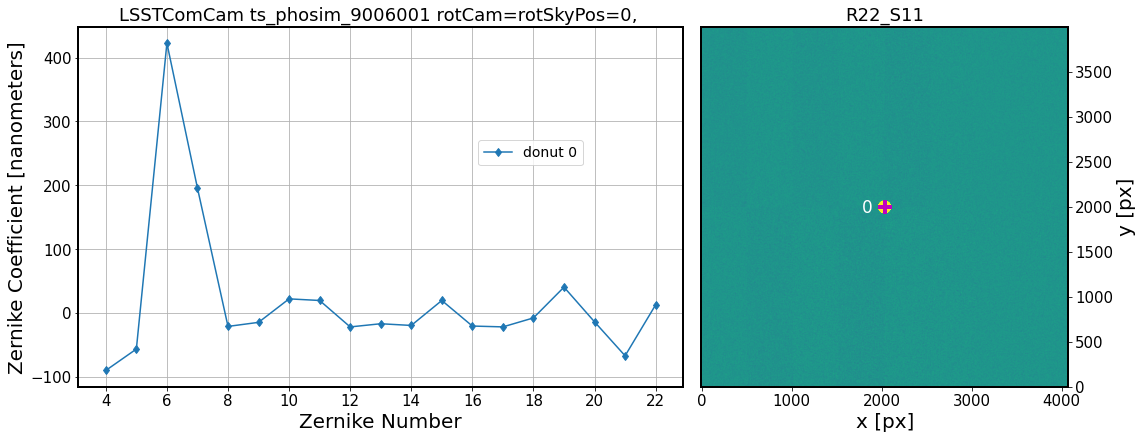

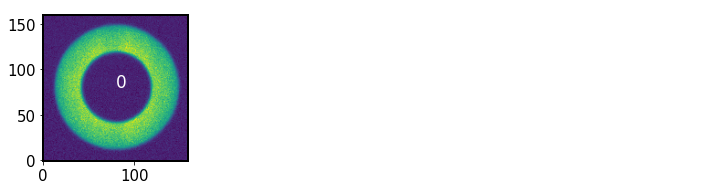

In [62]:
iterN = 0
data_dir = '/project/scichris/aos/rotation_DM-34065/test01_a_0/'
repoDir = os.path.join(data_dir, 'phosimData')
at.plotZernikeImage(repoDir=repoDir,
                   collection=f'ts_phosim_90060{iterN}1',
                   instrument='LSSTComCam',
                   detector='R22_S11',
                   titleAdd= 'rotCam=rotSkyPos=0, ')



ok, now `cmd` file has no `izernike` commands at all : 
    
    backgroundmode 0
    raydensity 0.0
    perturbationmode 1
    trackingmode 0
    cleartracking
    clearclouds
    lascatprob 0.0
    contaminationmode 0
    diffractionmode 1
    straylight 0
    detectormode 0
    centroidfile 1

## rotCam = -30, no izernike cmd 

{'detector': 'R22_S11', 'instrument': 'LSSTComCam', 'exposure': 4021123106001}
{'detector': 'R22_S11', 'instrument': 'LSSTComCam', 'visit': 4021123106001}


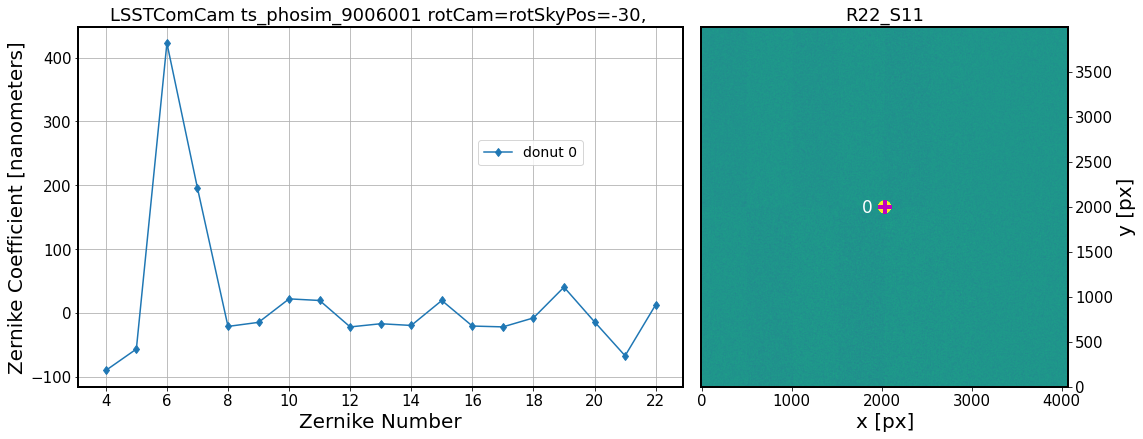

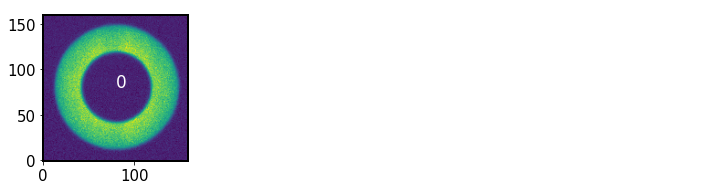

In [58]:
iterN = 0
data_dir = '/project/scichris/aos/rotation_DM-34065/test01_a_30n/'
repoDir = os.path.join(data_dir, 'phosimData')
at.plotZernikeImage(repoDir=repoDir,
                   collection=f'ts_phosim_90060{iterN}1',
                   instrument='LSSTComCam',
                   detector='R22_S11',
                   titleAdd= 'rotCam=rotSkyPos=-30, ')

## rotCam = 30, no izernike cmd 

{'detector': 'R22_S11', 'instrument': 'LSSTComCam', 'exposure': 4021123106001}
{'detector': 'R22_S11', 'instrument': 'LSSTComCam', 'visit': 4021123106001}


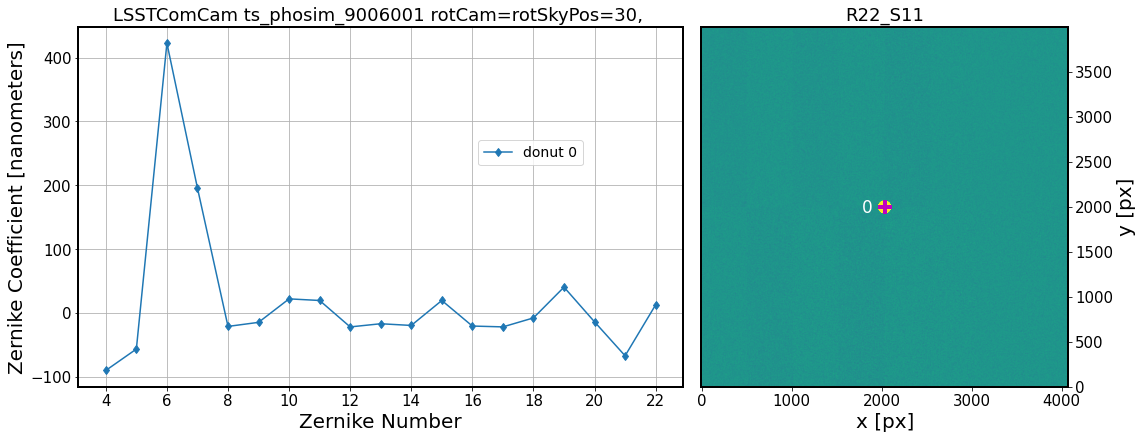

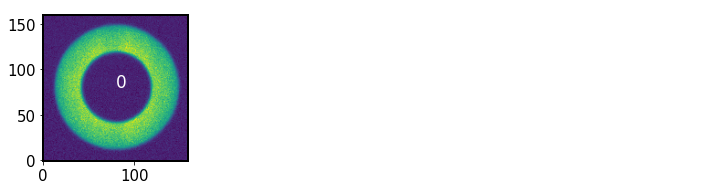

In [59]:
iterN = 0
data_dir = '/project/scichris/aos/rotation_DM-34065/test01_a_30/'
repoDir = os.path.join(data_dir, 'phosimData')
at.plotZernikeImage(repoDir=repoDir,
                   collection=f'ts_phosim_90060{iterN}1',
                   instrument='LSSTComCam',
                   detector='R22_S11',
                   titleAdd= 'rotCam=rotSkyPos=30, ')

## rotCam = 60, no izernike cmd 

{'detector': 'R22_S11', 'instrument': 'LSSTComCam', 'exposure': 4021123106001}
{'detector': 'R22_S11', 'instrument': 'LSSTComCam', 'visit': 4021123106001}


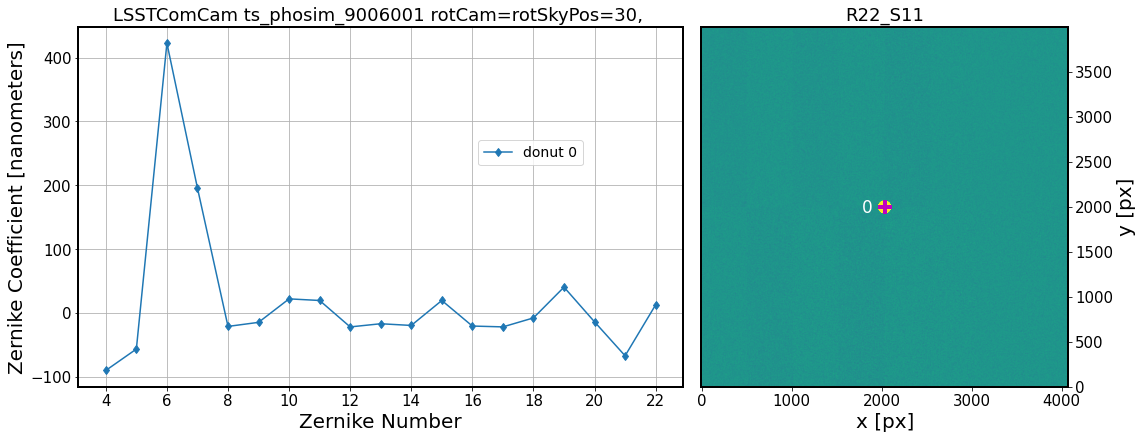

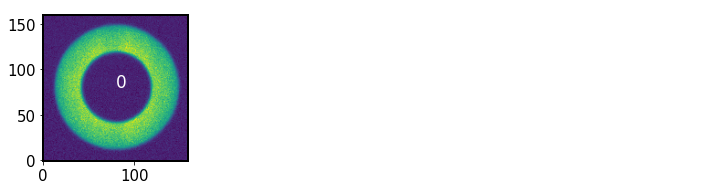

In [60]:
iterN = 0
data_dir = '/project/scichris/aos/rotation_DM-34065/test01_a_60/'
repoDir = os.path.join(data_dir, 'phosimData')
at.plotZernikeImage(repoDir=repoDir,
                   collection=f'ts_phosim_90060{iterN}1',
                   instrument='LSSTComCam',
                   detector='R22_S11',
                   titleAdd= 'rotCam=rotSkyPos=30, ')

## Summarize different rotation angles with no perturbations, star directly on the boresight

In [64]:
iterN=0
collection=f'ts_phosim_90060{iterN}1'
instrument='LSSTComCam'
detector='R22_S11'

zkRawDic = {}
# read the data for various rotation angles 
for rotCamInDeg in [-30,0,30,60]:   

    if rotCamInDeg < 0:
        title = f'{str(rotCamInDeg)[1:]}n'
    else:
        title = f'{rotCamInDeg}'

    data_dir = f'/project/scichris/aos/rotation_DM-34065/test01_a_{title}/'
    print(data_dir)

    repoDir = os.path.join(data_dir, 'phosimData')

    # read in the data from the butler
    butler = dafButler.Butler(repoDir)

    dataId0 = dict(instrument=instrument)
    dataset = next(
        iter(
            butler.registry.queryDatasets(
                datasetType="postISRCCD", dataId=dataId0, collections=[collection]
            )
        )
    )

    expN = dataset.dataId["exposure"]

    # construct a dataId for zernikes and donut catalog:
    # switch exposure to visit
    dataId = {"detector": detector, "instrument": instrument, "visit": expN}
    print(dataId)
    # the raw Zernikes
    zkRaw = butler.get("zernikeEstimateRaw", dataId=dataId, collections=[collection])
    
    #store to a dictionary for plotting
    zkRawDic[rotCamInDeg] = zkRaw

/project/scichris/aos/rotation_DM-34065/test01_a_30n/
{'detector': 'R22_S11', 'instrument': 'LSSTComCam', 'visit': 4021123106001}
/project/scichris/aos/rotation_DM-34065/test01_a_0/
{'detector': 'R22_S11', 'instrument': 'LSSTComCam', 'visit': 4021123106001}
/project/scichris/aos/rotation_DM-34065/test01_a_30/
{'detector': 'R22_S11', 'instrument': 'LSSTComCam', 'visit': 4021123106001}
/project/scichris/aos/rotation_DM-34065/test01_a_60/
{'detector': 'R22_S11', 'instrument': 'LSSTComCam', 'visit': 4021123106001}


Text(0.5, 1.0, 'LSSTComCam ts_phosim_9006001 ')

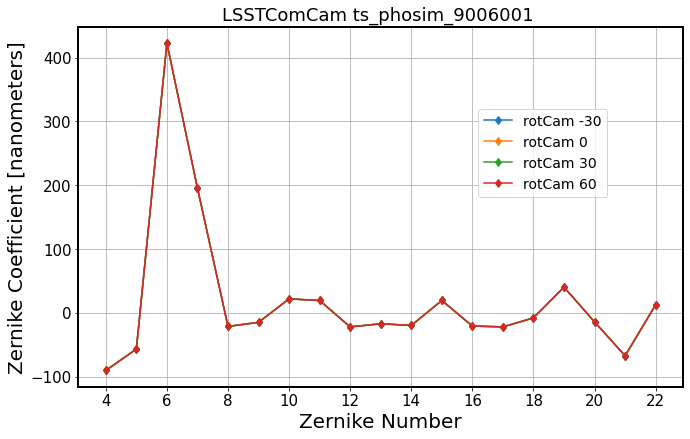

In [74]:
%matplotlib inline
import matplotlib.pyplot as plt
# plot the figure ...
fig = plt.figure(figsize=(14, 5))

##################################
# left - plot the fit results  ###
##################################

# add_axes([xmin,ymin,dx,dy])
ax1 = fig.add_axes([0, 0, 0.6, 1])

for rotCam, zkRaw in zkRawDic.items():
    ax1.plot(np.arange(4, 23), 1000 * zkRaw[0], "-d", label=f"rotCam {rotCam}")

ax1.set_xlabel(
    "Zernike Number",
)
ax1.set_ylabel(
    "Zernike Coefficient [nanometers]",
)
ax1.legend(fontsize=14, loc="center left", bbox_to_anchor=[0.65, 0.65])
ax1.set_xticks(np.arange(4, 23)[::2])
ax1.grid()

ax1.set_title(f"{instrument} {collection} ", fontsize=18)

So this confirms that for different rotation angles, the star directly on the boresight has exactly the same Zk values. 

# ASIDE: 

## Running the runCloseLoopTask with addCam = True : still has some izernikes

{'detector': 'R22_S12', 'instrument': 'LSSTComCam', 'exposure': 4021123106001}
{'detector': 'R22_S12', 'instrument': 'LSSTComCam', 'visit': 4021123106001}


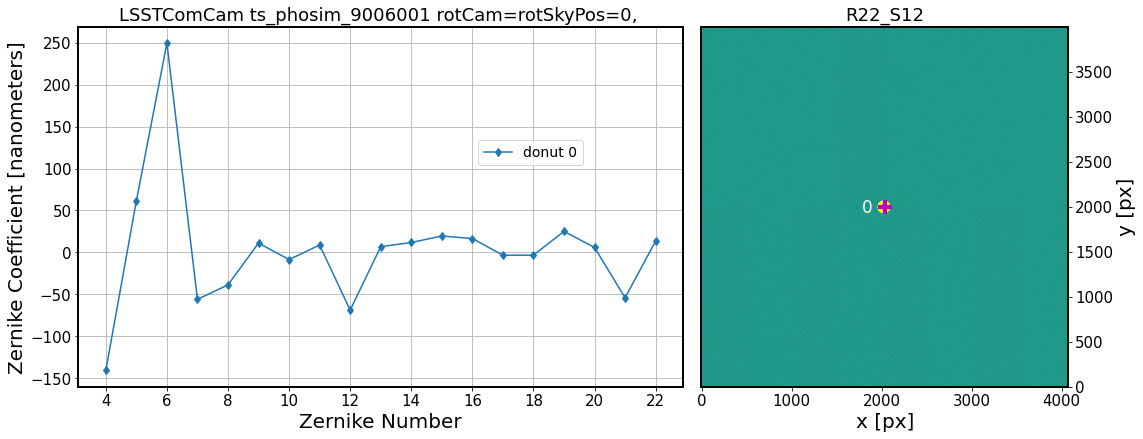

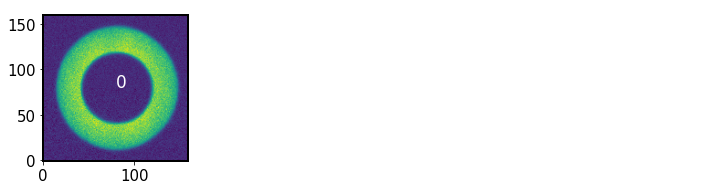

In [61]:
iterN = 0
data_dir = '/project/scichris/aos/rotation_DM-34065/test01/'
repoDir = os.path.join(data_dir, 'phosimData')
at.plotZernikeImage(repoDir=repoDir,
                   collection=f'ts_phosim_90060{iterN}1',
                   instrument='LSSTComCam',
                   detector='R22_S12',
                   titleAdd= 'rotCam=rotSkyPos=0, ')



The `test_01`  failed at `ts_ofc` for not recognizing `filterTypeName = 'ref'`. That's fine because I need to get the Zks which were recorded at a previous step.. That also had `addSubsys` not entirely off , so there were still `izernike` commands....


What's in the `inst` file?

    Opsim_obshistid 9006001 
    Opsim_filter 1 
    mjd 59580.0000000000 
    SIM_SEED 1000 
    rightascension 0.000000 
    declination 0.000000 
    rotskypos 0.000000 
    rottelpos 0
    SIM_VISTIME 15.0
    SIM_NSNAP 1
    Opsim_rawseeing -1
     ... all move commands are zero except ...
    move 10 -1500.0000 
    ... all move commands are zero except...

    camconfig 3 
    object  0	359.765300	-0.234700 15.000000 ../sky/sed_500.txt 0.0 0.0 0.0 0.0 0.0 0.0 star 0.0 none none 
    object  1	359.765300	 0.000000 15.000000 ../sky/sed_500.txt 0.0 0.0 0.0 0.0 0.0 0.0 star 1.0 none none 
    object  2	359.765300	 0.234700 15.000000 ../sky/sed_500.txt 0.0 0.0 0.0 0.0 0.0 0.0 star 2.0 none none 
    object  3	 0.000000	-0.234700 15.000000 ../sky/sed_500.txt 0.0 0.0 0.0 0.0 0.0 0.0 star 3.0 none none 
    object  4	 0.000000	 0.000000 15.000000 ../sky/sed_500.txt 0.0 0.0 0.0 0.0 0.0 0.0 star 4.0 none none 
    object  5	 0.000000	 0.234700 15.000000 ../sky/sed_500.txt 0.0 0.0 0.0 0.0 0.0 0.0 star 5.0 none none 
    object  6	 0.234700	-0.234700 15.000000 ../sky/sed_500.txt 0.0 0.0 0.0 0.0 0.0 0.0 star 6.0 none none 
    object  7	 0.234700	 0.000000 15.000000 ../sky/sed_500.txt 0.0 0.0 0.0 0.0 0.0 0.0 star 7.0 none none 
    object  8	 0.234700	 0.234700 15.000000 ../sky/sed_500.txt 0.0 0.0 0.0 0.0 0.0 0.0 star 8.0 none none 
    
What's in the `cmd` file? Despite having 

    tele.addSubSys(addCam=True, addM1M3=False, addM2=False)


(where `addCam` is to correct for the camera distortion), I have all these `izernike` as nonzero:
    
    backgroundmode 0
    raydensity 0.0
    perturbationmode 1
    trackingmode 0
    cleartracking
    clearclouds
    lascatprob 0.0
    contaminationmode 0
    diffractionmode 1
    straylight 0
    detectormode 0
    centroidfile 1
    izernike 3 0 -0.1258167 
    izernike 3 1 -0.001616955 
    izernike 3 2 -0.002070914 
    izernike 3 3 4.4348099999999996e-05 
    izernike 3 4 -6.999589999999999e-06 
    izernike 3 5 -1.457109e-05 
    izernike 3 6 1.6914830000000004e-06 
    izernike 3 7 1.147113e-06 
    izernike 3 8 3.3115449999999985e-06 
    izernike 3 9 5.439775e-07 
    izernike 3 10 -5.966822000000001e-07 
    izernike 3 11 -2.0380806999999998e-07 
    izernike 3 12 1.1271099999999998e-07 
    izernike 3 13 -2.778230999999999e-06 
    izernike 3 14 3.849267e-07 
    izernike 3 15 3.045193e-07 
    izernike 3 16 2.8407579999999994e-07 
    izernike 3 17 -1.1758978e-07 
    izernike 3 18 1.2279370000000003e-07 
    izernike 3 19 -8.620499999999941e-09 
    izernike 3 20 1.8536079999999997e-06 
    izernike 3 21 1.4632919999999998e-06 
    izernike 3 22 2.32770162e-07 
    izernike 3 23 -5.8461698e-07 
    izernike 3 24 -4.583300000000001e-08 
    izernike 3 25 9.459833e-08 
    izernike 3 26 5.36113e-07 
    izernike 3 27 6.940370000000004e-07 
    izernike 4 0 -0.1256541 
    izernike 4 1 -0.001616755 
    izernike 4 2 -0.002070914 
    izernike 4 3 -7.701660000000002e-06 
    izernike 4 4 -6.960809999999997e-06 
    izernike 4 5 -1.44843e-05 
    izernike 4 6 1.4177960000000005e-06 
    izernike 4 7 9.50066e-07 
    izernike 4 8 3.009611000000001e-06 
    izernike 4 9 7.218136900000001e-07 
    izernike 4 10 -1.1903179999999995e-06 
    izernike 4 11 -5.203321999999999e-07 
    izernike 4 12 -8.788973000000001e-08 
    izernike 4 13 -2.993032000000001e-06 
    izernike 4 14 -1.8372899999999957e-08 
    izernike 4 15 1.401979e-07 
    izernike 4 16 2.6614969999999995e-07 
    izernike 4 17 -2.925446e-07 
    izernike 4 18 1.6342430000000005e-07 
    izernike 4 19 -1.2696357999999998e-07 
    izernike 4 20 1.4665549999999999e-06 
    izernike 4 21 8.579149999999996e-07 
    izernike 4 22 -2.7379590000000003e-08 
    izernike 4 23 -2.1223706e-07 
    izernike 4 24 -7.212779999999998e-08 
    izernike 4 25 -2.0013024e-07 
    izernike 4 26 -1.4336359000000002e-08 
    izernike 4 27 1.3356389999999996e-06 
    izernike 5 0 -0.12184639999999997 
    izernike 5 1 -0.0010853770000000002 
    izernike 5 2 -0.0013713980000000002 
    izernike 5 3 -7.49097e-05 
    izernike 5 4 -6.300490000000001e-06 
    izernike 5 5 -1.4020399999999999e-05 
    izernike 5 6 1.7866930000000002e-06 
    izernike 5 7 8.099300000000001e-07 
    izernike 5 8 -1.7397860000000002e-05 
    izernike 5 9 -6.053750000000001e-07 
    izernike 5 10 9.1749e-06 
    izernike 5 11 5.020133e-07 
    izernike 5 12 6.510341e-07 
    izernike 5 13 1.918507999999999e-06 
    izernike 5 14 -3.997239999999999e-07 
    izernike 5 15 -1.2225010000000002e-07 
    izernike 5 16 -2.2657509999999997e-07 
    izernike 5 17 -5.8879999999999e-09 
    izernike 5 18 1.6307279999999994e-06 
    izernike 5 19 6.813330000000002e-08 
    izernike 5 20 -6.184790000000001e-07 
    izernike 5 21 -9.32601e-07 
    izernike 5 22 -9.376800000000002e-08 
    izernike 5 23 -2.8391930000000007e-07 
    izernike 5 24 -2.5240521e-07 
    izernike 5 25 -2.94873e-07 
    izernike 5 26 8.17097e-08 
    izernike 5 27 1.4925870000000002e-06 
    izernike 6 0 -0.12161510000000003 
    izernike 6 1 -0.001085177 
    izernike 6 2 -0.0013713980000000002 
    izernike 6 3 -1.3389469999999996e-05 
    izernike 6 4 -6.3992699999999995e-06 
    izernike 6 5 -1.3741009999999997e-05 
    izernike 6 6 1.7462500000000004e-06 
    izernike 6 7 6.699089999999998e-07 
    izernike 6 8 -1.7416560000000003e-05 
    izernike 6 9 -9.78397e-07 
    izernike 6 10 7.325239999999998e-06 
    izernike 6 11 7.486285000000002e-07 
    izernike 6 12 2.7602700000000004e-07 
    izernike 6 13 1.6485209999999995e-06 
    izernike 6 14 8.159399999999982e-08 
    izernike 6 15 -1.8012089999999998e-07 
    izernike 6 16 -1.6176289999999997e-07 
    izernike 6 17 -2.9730110000000007e-07 
    izernike 6 18 1.7474100000000003e-06 
    izernike 6 19 -5.6457600000000046e-08 
    izernike 6 20 -8.998109999999999e-07 
    izernike 6 21 -2.194978e-06 
    izernike 6 22 -4.3885520000000006e-07 
    izernike 6 23 2.173064e-07 
    izernike 6 24 -1.69545231e-07 
    izernike 6 25 -3.7171049999999995e-07 
    izernike 6 26 -8.431259e-08 
    izernike 6 27 2.1236900000000002e-06 
    izernike 9 0 0.0 
    izernike 9 1 0.0 
    izernike 9 2 0.0 
    izernike 9 3 0.0 
    izernike 9 4 0.0 
    izernike 9 5 0.0 
    izernike 9 6 0.0 
    izernike 9 7 0.0 
    izernike 9 8 0.0 
    izernike 9 9 0.0 
    izernike 9 10 0.0 
    izernike 9 11 0.0 
    izernike 9 12 0.0 
    izernike 9 13 0.0 
    izernike 9 14 0.0 
    izernike 9 15 0.0 
    izernike 9 16 0.0 
    izernike 9 17 0.0 
    izernike 9 18 0.0 
    izernike 9 19 0.0 
    izernike 9 20 0.0 
    izernike 9 21 0.0 
    izernike 9 22 0.0 
    izernike 9 23 0.0 
    izernike 9 24 0.0 
    izernike 9 25 0.0 
    izernike 9 26 0.0 
    izernike 9 27 0.0 
    izernike 10 0 0.0 
    izernike 10 1 0.0 
    izernike 10 2 0.0 
    izernike 10 3 0.0 
    izernike 10 4 0.0 
    izernike 10 5 0.0 
    izernike 10 6 0.0 
    izernike 10 7 0.0 
    izernike 10 8 0.0 
    izernike 10 9 0.0 
    izernike 10 10 0.0 
    izernike 10 11 0.0 
    izernike 10 12 0.0 
    izernike 10 13 0.0 
    izernike 10 14 0.0 
    izernike 10 15 0.0 
    izernike 10 16 0.0 
    izernike 10 17 0.0 
    izernike 10 18 0.0 
    izernike 10 19 0.0 
    izernike 10 20 0.0 
    izernike 10 21 0.0 
    izernike 10 22 0.0 
    izernike 10 23 0.0 
    izernike 10 24 0.0 
    izernike 10 25 0.0 
    izernike 10 26 0.0 
    izernike 10 27 0.0 

    
`izernike 3:6` corresponds to `SurfaceType.L1F, SurfaceType.L1B, SurfaceType.L2F,SurfaceType.L2B`, i.e. the lens distortions...
    
    
Try not doing `addSubSys`  - that way https://github.com/lsst-ts/ts_phosim/blob/ac34fe47154361e96cefcb687a3e12d8c0a515b3/python/lsst/ts/phosim/telescope/TeleFacade.py#L418 `addCam=False`, as well as `addM1M3` and `addM2` ...



    
    

## Running imgCloseLoop with m1m3Ferr = 0

That was done  thinking that just setting `m1m3Ferr = 0` would turn off the perturbations, but it doesn't.... 


    mkdir /project/scichris/aos/rotation_DM-34065/test1_rotCam_0/

make a slurm file `runSlurm_0.sl` 

    #!/bin/bash -l 
    #SBATCH --partition normal 
    #SBATCH --nodes 3
    #SBATCH --ntasks 60
    #SBATCH -t 30:00:00 
    #SBATCH --job-name rot0
    echo "starting at `date` on `hostname`" 
    pwd 
    
    python /project/scichris/aos/ts_phosim/bin.src/imgCloseLoop.py --inst comcam --numOfProc 55 --rotCam 0 --m1m3FErr 0 --clobber --output /project/scichris/aos/rotation_DM-34065/test1_rotCam_0/
    
    echo "ended at `date` on `hostname`"
    
    
run with `sbatch runSlurm_0.sl` (Do not pass  `boresightDeg`  so that the default `0,0` is used ). 

This is with  configuration `rotCam -- > rotSkyPos`,  and `rotTelPos` as a free parameter. 



Also  run with other rotation angles; use a similar slurm file but change the `rotCam` : 
    
    cp runSlurm_0.sl runSlurm_30.sl  # 30 degrees
    cp runSlurm_30.sl runSlurm_60n.sl # -60 degrees 
    

In [ ]:
%matplotlib inline
data_dir = '/project/scichris/aos/rotation_DM-34065/test1_rotCam_0/'
at.plotIterationSummary(data_dir, iterNum=4, 
                        suptitle='imgCloseLoop, rotCam = 0 = rotSkyPos, rotTelPos=0', 
                    )

iterN = 0
repoDir = os.path.join(data_dir, 'phosimData')
at.plotZernikeImage(repoDir=repoDir,
                   collection=f'ts_phosim_90060{iterN}1',
                   instrument='LSSTComCam',
                   detector='R22_S11',
                   titleAdd= 'rotCam=rotSkyPos=0, ')



iterN = 1
repoDir = os.path.join(data_dir, 'phosimData')
at.plotZernikeImage(repoDir=repoDir,
                   collection=f'ts_phosim_90060{iterN}1',
                   instrument='LSSTComCam',
                   detector='R22_S11',
                   titleAdd= 'rotCam=rotSkyPos=0, ')


iterN = 2
repoDir = os.path.join(data_dir, 'phosimData')
at.plotZernikeImage(repoDir=repoDir,
                   collection=f'ts_phosim_90060{iterN}1',
                   instrument='LSSTComCam',
                   detector='R22_S11',
                   titleAdd= 'rotCam=rotSkyPos=0, ')


%matplotlib inline
data_dir = '/project/scichris/aos/rotation_DM-34065/test1_rotCam_30/'
at.plotIterationSummary(data_dir, iterNum=4, 
                        suptitle='imgCloseLoop, rotCam = 30 = rotSkyPos', 
                    )



iterN = 0
data_dir = '/project/scichris/aos/rotation_DM-34065/test1_rotCam_30/'
repoDir = os.path.join(data_dir, 'phosimData')
at.plotZernikeImage(repoDir=repoDir,
                   collection=f'ts_phosim_90060{iterN}1',
                   instrument='LSSTComCam',
                   detector='R22_S11',
                   titleAdd= 'rotCam=rotSkyPos=0, ')

iterN = 1
data_dir = '/project/scichris/aos/rotation_DM-34065/test1_rotCam_30/'
repoDir = os.path.join(data_dir, 'phosimData')
at.plotZernikeImage(repoDir=repoDir,
                   collection=f'ts_phosim_90060{iterN}1',
                   instrument='LSSTComCam',
                   detector='R22_S11',
                   titleAdd= 'rotCam=rotSkyPos=0, ')


%matplotlib inline
data_dir = '/project/scichris/aos/rotation_DM-34065/test1_rotCam_60n/'
at.plotIterationSummary(data_dir, iterNum=4, 
                        suptitle='imgCloseLoop, rotCam = 60 = rotSkyPos', 
                    )

iterN = 0
data_dir = '/project/scichris/aos/rotation_DM-34065/test1_rotCam_60n/'
repoDir = os.path.join(data_dir, 'phosimData')
at.plotZernikeImage(repoDir=repoDir,
                   collection=f'ts_phosim_90060{iterN}1',
                   instrument='LSSTComCam',
                   detector='R22_S11',
                   titleAdd= 'rotCam=rotSkyPos=60, ')



iterN = 1
data_dir = '/project/scichris/aos/rotation_DM-34065/test1_rotCam_60n/'
repoDir = os.path.join(data_dir, 'phosimData')
at.plotZernikeImage(repoDir=repoDir,
                   collection=f'ts_phosim_90060{iterN}1',
                   instrument='LSSTComCam',
                   detector='R22_S11',
                   titleAdd= 'rotCam=rotSkyPos=60, ')



One way to turn off all perturbations is to take the cmd and inst files above, but remove all the `izernike` and `surfacemap` commands. Run phosim, repackage, and proceed with the usual pipeline.

    backgroundmode 0
    raydensity 0.0
    perturbationmode 1
    trackingmode 0
    cleartracking
    clearclouds
    lascatprob 0.0
    contaminationmode 0
    diffractionmode 1
    straylight 0
    detectormode 0
    centroidfile 1

In `/project/scichris/aos/rotation_DM-34065/star.cmd`

Then use `test1_rotCam_0/iter0/pert/starExtra.inst` and `test1_rotCam_0/iter0/pert/starIntra.inst` for inst files for rotation 0, `test1_rotcam30/iter0/pert/starExtra.inst`... etc for rotation 30, and `rotcam60n` for rotation -60. 

The command to run phosim was (from `slurm-60473.out`):

    python /project/scichris/aos/phosim_syseng4/phosim.py /project/scichris/aos/rotation_DM-34065/test1_rotCam_0/iter0/pert/starExtra.inst -i comcam -e 1 -c /project/scichris/aos/rotation_DM-34065/test1_rotCam_0/iter0/pert/star.cmd -p 55 -o /project/scichris/aos/rotation_DM-34065/test1_rotCam_0/iter0/img/extra -w /project/scichris/aos/rotation_DM-34065/test1_rotCam_0/iter0/img/extra > /project/scichris/aos/rotation_DM-34065/test1_rotCam_0/iter0/img/extra/starExtraPhoSim.log 2>&1
